# **Connect to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
# Liệt kê các file trong thư mục để kiểm tra sự tồn tại của file mô hình
model_path = "/content/drive/MyDrive/"
print(os.listdir(model_path))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['Classroom', '[HaUI] CV Intern Data Engineer - Ngo Anh Tuan.pdf', 'Colab Notebooks', 'xemay.jpg', 'wpod-net_update1.h5', '.ipynb_checkpoints', 'AnhGoc.zip', 'GreenParking', 'License_character_recognition.h5', 'saved_model.h5', 'Dataset', 'model.h5', 'abc.jpg', 'Tài liệu không có tiêu đề.gdoc', 'wpod-net_update1.json', 'model_v1.h5', 'model_v2.h5', 'model_v3.h5', 'model_v4.h5', 'model_v5.h5', 'NhanDienKyTu.h5', 'KyTu_CoNhan', 'transform_labeled', 'Augment_Labeled', 'model_v6.h5', 'model_v7.h5', 'model_v8.h5', 'model_v8_active_finetuned.h5', 'model_v8_finetuned.h5', 'model_v9.h5', 'model_v9_finetuned.h5', 'model_v10.h5', 'model_v10_finetuned.h5', 'model_v10_active_finetuned.h5', 'model_v10_active.h5', 'model_v12.h5', 'model_v12_finetuned.h5', 'model_v12_active_finetuned.h5', 'model_v12_active_learning_finetuned.h5', 'model_v14.h5', 'model_v14_finetun

# **Setup môi trường**

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  

# **Step By Step**

# **Deploy WPOD NET**

In [ ]:
from os.path import splitext
import cv2
import numpy as np
from keras.models import model_from_json


class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

# Hàm normalize ảnh
def im2single(Image):
    return Image.astype('float32') / 255

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())

    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)

    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels

def load_model(path):
    path = splitext(path)[0]
    with open('%s.json' % path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json, custom_objects={})
    model.load_weights('%s.h5' % path)
    return model

def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T

        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Hàm tái tạo từ predict value thành biến số, cắt từ ảnh chính ra biển số,  nhãn...
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 250)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))

    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    print("final lable frontal: ", final_labels_frontal)

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)

            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
    print("final lable:", final_labels)
    return final_labels, TLp, lp_type

def detect_lp(model, I, max_dim, lp_threshold):

    # Tính factor resize ảnh
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img

    # Tính W và H mới sau khi resize
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()

    # Tiến hành resize ảnh
    Iresized = cv2.resize(I, (w, h))

    T = Iresized.copy()

    # Chuyển thành Tensor
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))

    # Tiến hành detect biển số bằng Wpod-net pretrain
    Yr = model.predict(T)

    # Remove các chiều =1 của Yr
    Yr = np.squeeze(Yr)

    print("Yr shape: ", Yr.shape)

    # Tái tạo và trả về các biến gồm: Nhãn, Ảnh biến số, Loại biển số (1: dài: 2 vuông)
    L, TLp, lp_type = reconstruct(I, Iresized, Yr, lp_threshold)

    return L, TLp, lp_type

Số lượng ảnh trong thư mục: 1158


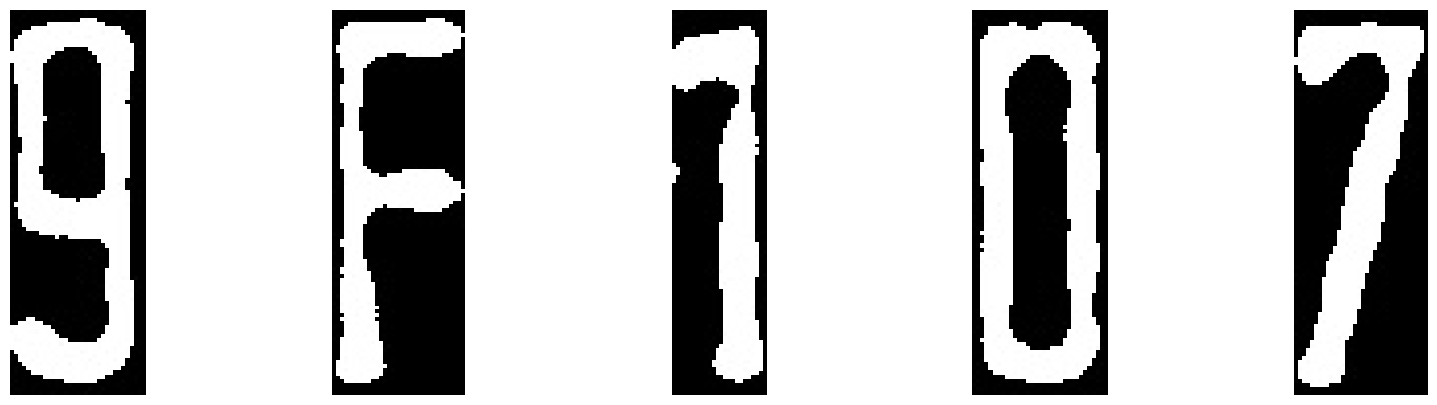

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

folder_path = '/content/drive/MyDrive/transform_labeled'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print("Số lượng ảnh trong thư mục:", len(image_files))
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Hiển thị 5 ảnh đầu tiên
for ax, image_file in zip(axes, image_files[:5]):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi màu từ BGR sang RGB
    ax.imshow(image)
    ax.axis('off')
plt.show()



# **Phân đoạn biển số**

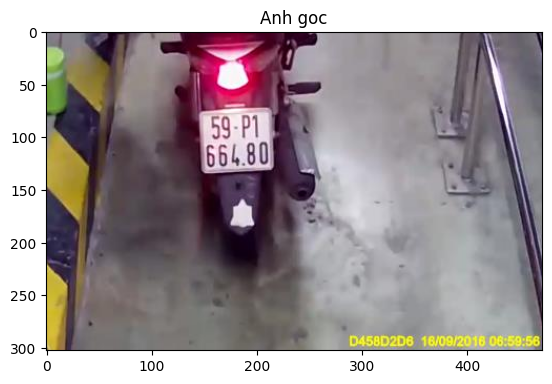

1/1 [==============================] - 1s 1s/step
Yr shape:  (28, 43, 8)
final lable frontal:  [<__main__.DLabel object at 0x7d9118ae5270>]
final lable: [<__main__.DLabel object at 0x7d9118ae6290>]


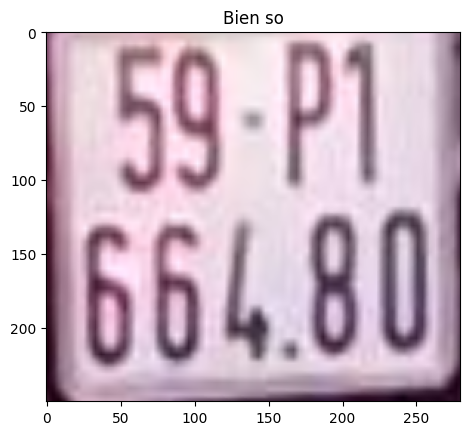

In [ ]:
import cv2
import matplotlib.pyplot as plt
# from lib_detection import load_model, detect_lp, im2single

# Đường dẫn ảnh, các bạn đổi tên file tại đây để thử nhé
img_path = "/content/drive/MyDrive/GreenParking/000001.jpg"

# Load model LP detection
wpod_net_path = "/content/drive/MyDrive/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

# Đọc file ảnh đầu vào
Ivehicle = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(Ivehicle, cv2.COLOR_BGR2RGB))
plt.title("Anh goc")
plt.show()

# Kích thước lớn nhất và nhỏ nhất của 1 chiều ảnh
Dmax = 608
Dmin = 288

# Lấy tỷ lệ giữa W và H của ảnh và tìm ra chiều nhỏ nhất
ratio = float(max(Ivehicle.shape[:2])) / min(Ivehicle.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

# Detect license plate in the image
_, LpImg, lp_type = detect_lp(wpod_net, im2single(Ivehicle), bound_dim, lp_threshold=0.5)

# Nếu tìm thấy biển số, hiển thị ảnh biển số đầu tiên
if len(LpImg):
    plt.imshow(cv2.cvtColor(LpImg[0], cv2.COLOR_RGB2BGR))
    plt.title("Bien so")
    plt.show()


1/1 [==============================] - 1s 683ms/step
Yr shape:  (28, 43, 8)
final lable frontal:  [<__main__.DLabel object at 0x7d90c2114a60>]
final lable: [<__main__.DLabel object at 0x7d90c2115c30>]


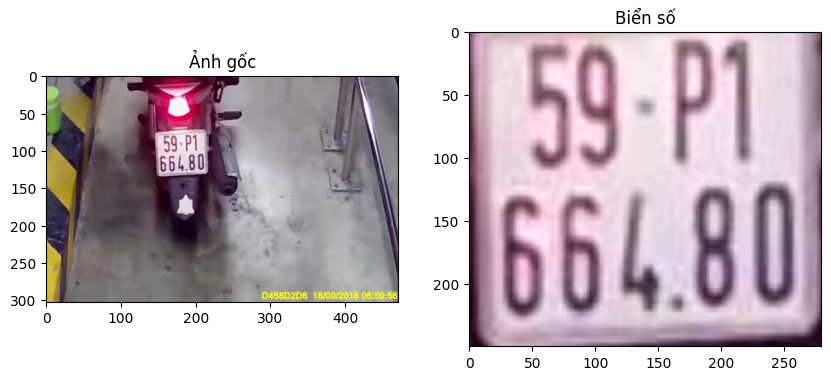

In [ ]:
import cv2
import matplotlib.pyplot as plt
# from lib_detection import load_model, detect_lp, im2single

# Đường dẫn ảnh, các bạn đổi tên file tại đây để thử nhé
img_path = "/content/drive/MyDrive/GreenParking/000001.jpg"

# Load model LP detection
wpod_net_path = "/content/drive/MyDrive/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

# Đọc file ảnh đầu vào
Ivehicle = cv2.imread(img_path)

# Kích thước lớn nhất và nhỏ nhất của 1 chiều ảnh
Dmax = 608
Dmin = 288

# Lấy tỷ lệ giữa W và H của ảnh và tìm ra chiều nhỏ nhất
ratio = float(max(Ivehicle.shape[:2])) / min(Ivehicle.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

# Detect license plate in the image
_, LpImg, lp_type = detect_lp(wpod_net, im2single(Ivehicle), bound_dim, lp_threshold=0.5)

# Tạo figure với 1 hàng và 2 cột
plt.figure(figsize=(10, 5))

# Hiển thị ảnh gốc
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(Ivehicle, cv2.COLOR_BGR2RGB))
plt.title("Ảnh gốc")

# Nếu tìm thấy biển số, hiển thị ảnh biển số đầu tiên
if len(LpImg):
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(LpImg[0], cv2.COLOR_RGB2BGR))
    plt.title("Biển số")

# Hiển thị cả hai ảnh
plt.show()


# **Phân đoạn ký tự**

In [ ]:
import cv2
import numpy as np
import functools
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import ndimage
from skimage.feature import peak_local_max
import time
from IPython.display import clear_output
import os

def preprocess_image(LpImg):
    gray = cv2.cvtColor(LpImg, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray)
    blurred = cv2.GaussianBlur(enhanced_gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)
    return thresh, enhanced_gray

def connected_components_analysis(thresh, LpImg):
    _, labels = cv2.connectedComponents(thresh)
    mask = np.zeros(thresh.shape, dtype="uint8")
    total_pixels = LpImg.shape[0] * LpImg.shape[1]
    lower = total_pixels // 70
    upper = total_pixels // 20

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        if lower < numPixels < upper:
            mask = cv2.add(mask, labelMask)

    return mask

def is_near_border(rect, img_height, img_width, border_threshold=2):
    x, y, w, h = rect
    return (x <= border_threshold or y <= border_threshold or
            x + w >= img_width - border_threshold or
            y + h >= img_height - border_threshold)

def find_and_sort_contours(mask, LpImg):
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]

    height, width = LpImg.shape[:2]
    boundingBoxes = [rect for rect in boundingBoxes if not is_near_border(rect, height, width)]

    def compare(rect1, rect2):
        if abs(rect1[1] - rect2[1]) > 10:
            return rect1[1] - rect2[1]
        else:
            return rect1[0] - rect2[0]

    boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))
    return boundingBoxes


def draw_bounding_boxes(LpImg, boundingBoxes):
    # Tạo một bản sao của LpImg để vẽ bounding boxes
    LpImg_copy = LpImg.copy()

    for (x, y, w, h) in boundingBoxes:
        cv2.rectangle(LpImg_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(LpImg_copy, cv2.COLOR_BGR2RGB))
    plt.title('Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

def save_cropped_characters(LpImg, boundingBoxes, output_dir, label_string, base_filename):
    if len(boundingBoxes) != len(label_string):
        print("Số lượng bounding boxes không khớp với độ dài chuỗi ký tự.")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, (x, y, w, h) in enumerate(boundingBoxes):
        cropped_char = LpImg[y:y+h, x:x+w]
        char_label = label_string[i]
        new_filename = f"{base_filename}{char_label}.png"
        output_path = os.path.join(output_dir, new_filename)
        cv2.imwrite(output_path, cropped_char)
        print(f"Saved character '{char_label}' at {output_path}")




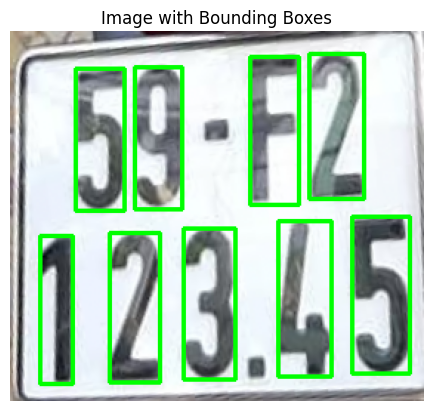

KeyboardInterrupt: Interrupted by user

In [ ]:
LpImg = np.array(LpImg[0] * 255, dtype=np.uint8)

if LpImg is not None:
  thresh, gray = preprocess_image(LpImg)
  mask = connected_components_analysis(thresh, LpImg)
  boundingBoxes = find_and_sort_contours(mask, LpImg)

# Nếu tìm thấy biển số và các ký tự
if LpImg is not None and boundingBoxes is not None:
    # Vẽ các bounding boxes lên hình ảnh biển số
    draw_bounding_boxes(LpImg, boundingBoxes)

    # Ví dụ cách sử dụng hàm đã cập nhật
    base_filename = "000001.jpg"  # Tên file ban đầu không có đuôi
    output_dir = "output"

    time.sleep(1)  # Thêm khoảng nghỉ ngắn để đảm bảo hình ảnh hiển thị

    label_string = input(f"Enter label for {base_filename}: ").strip()
    clear_output(wait=True)
    # Gọi hàm với các tham số mới
    save_cropped_characters(LpImg, boundingBoxes, output_dir, label_string, base_filename)
else:
    print("Không tìm thấy biển số hoặc ký tự.")

# **From Folder to Folder**

# **Function**

In [ ]:
from os.path import splitext
import cv2
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import ndimage
from skimage.feature import peak_local_max
import time
from IPython.display import clear_output
import os
import functools

class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

# Hàm normalize ảnh
def im2single(Image):
    return Image.astype('float32') / 255

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())

    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)

    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels

def load_model(path):
    path = splitext(path)[0]
    with open('%s.json' % path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json, custom_objects={})
    model.load_weights('%s.h5' % path)
    return model

def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T

        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Hàm tái tạo từ predict value thành biến số, cắt từ ảnh chính ra biển số,  nhãn...
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 250)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))

    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    print("final lable frontal: ", final_labels_frontal)

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)

            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
    print("final lable:", final_labels)
    return final_labels, TLp, lp_type

def detect_lp(model, I, max_dim, lp_threshold):

    # Tính factor resize ảnh
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img

    # Tính W và H mới sau khi resize
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()

    # Tiến hành resize ảnh
    Iresized = cv2.resize(I, (w, h))

    T = Iresized.copy()

    # Chuyển thành Tensor
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))

    # Tiến hành detect biển số bằng Wpod-net pretrain
    Yr = model.predict(T)

    # Remove các chiều =1 của Yr
    Yr = np.squeeze(Yr)

    print("Yr shape: ", Yr.shape)

    # Tái tạo và trả về các biến gồm: Nhãn, Ảnh biến số, Loại biển số (1: dài: 2 vuông)
    L, TLp, lp_type = reconstruct(I, Iresized, Yr, lp_threshold)

    return L, TLp, lp_type


def reduce_glare(img):
    img_blurred = cv2.GaussianBlur(img, (5, 5), 0)
    img_reduced_glare = cv2.addWeighted(img, 1.5, img_blurred, -0.5, 0)
    return img_reduced_glare


def preprocess_image(LpImg):

    gray = cv2.cvtColor(LpImg, cv2.COLOR_BGR2GRAY)
    img_reduced_glare = reduce_glare(gray)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(img_reduced_glare)

    # Thay thế GaussianBlur bằng BilateralFilter để giữ lại cạnh của ký tự
    filtered = cv2.bilateralFilter(enhanced_gray, 9, 75, 75)

    # Inpainting để xử lý vùng bị bẩn (tuỳ chọn)
    mask = cv2.threshold(filtered, 240, 255, cv2.THRESH_BINARY)[1]
    inpainted = cv2.inpaint(filtered, mask, 3, cv2.INPAINT_TELEA)

    thresh = cv2.adaptiveThreshold(inpainted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 45, 15)
    return thresh, enhanced_gray

def connected_components_analysis(thresh, LpImg):
    _, labels = cv2.connectedComponents(thresh)
    mask = np.zeros(thresh.shape, dtype="uint8")
    total_pixels = LpImg.shape[0] * LpImg.shape[1]
    lower = total_pixels // 70
    upper = total_pixels // 20

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        if lower < numPixels < upper:
            mask = cv2.add(mask, labelMask)

    return mask

def is_near_border(rect, img_height, img_width, border_threshold=2):
    x, y, w, h = rect
    return (x <= border_threshold or y <= border_threshold or
            x + w >= img_width - border_threshold or
            y + h >= img_height - border_threshold)

def find_and_sort_contours(mask, LpImg):
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]

    height, width = LpImg.shape[:2]
    boundingBoxes = [rect for rect in boundingBoxes if not is_near_border(rect, height, width)]

    def compare(rect1, rect2):
        if abs(rect1[1] - rect2[1]) > 10:
            return rect1[1] - rect2[1]
        else:
            return rect1[0] - rect2[0]

    boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))
    return boundingBoxes


def draw_bounding_boxes(LpImg, boundingBoxes):
    # Tạo một bản sao của LpImg để vẽ bounding boxes
    LpImg_copy = LpImg.copy()

    for (x, y, w, h) in boundingBoxes:
        cv2.rectangle(LpImg_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(LpImg_copy, cv2.COLOR_BGR2RGB))
    plt.title('Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

def save_cropped_characters(LpImg, boundingBoxes, output_dir, label_string, base_filename):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, (x, y, w, h) in enumerate(boundingBoxes):
        cropped_char = LpImg[y:y+h, x:x+w]
        char_label = label_string[i]
        new_filename = f"{base_filename}_{i+1:02d}_{char_label}.jpg"
        output_path = os.path.join(output_dir, new_filename)
        cv2.imwrite(output_path, cropped_char)
        print(f"Saved character '{char_label}' at {output_path}")




# **Call Function**

000001.jpg
1/1 [==============================] - 0s 474ms/step
Yr shape:  (28, 43, 8)
final lable frontal:  [<__main__.DLabel object at 0x7d910c242200>]
final lable: [<__main__.DLabel object at 0x7d910c2408b0>]


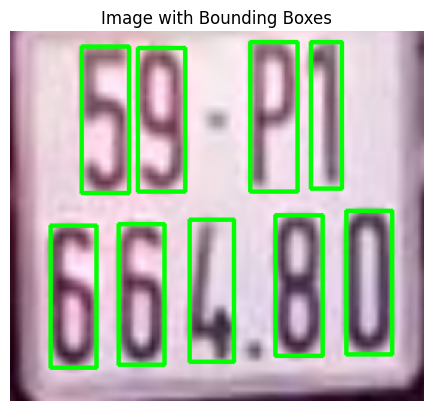

KeyboardInterrupt: Interrupted by user

In [ ]:

input_dir = "/content/drive/MyDrive/GreenParking"  # Đường dẫn tới thư mục chứa các file ảnh đầu vào
output_dir = "/content/drive/MyDrive/KyTu_CoNhan"  # Đường dẫn tới thư mục để lưu các file ký tự có nhãn đã cắt

# Load model LP detection
wpod_net_path = "/content/drive/MyDrive/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

# Kích thước lớn nhất và nhỏ nhất của 1 chiều ảnh
Dmax = 608
Dmin = 288

# Số lượng ảnh cần đánh nhãn
num_images = 50


# Duyệt qua các file ảnh trong thư mục input_dir
for i in range(1,201):
    file_name = f"{i:06d}.jpg"
    print(file_name)
    img_path = os.path.join(input_dir, file_name)

    # Kiểm tra xem file ảnh có tồn tại không
    if not os.path.exists(img_path):
        print(f"File {file_name} không tồn tại trong thư mục {input_dir}.")
        continue

    # Đọc file ảnh đầu vào
    Ivehicle = cv2.imread(img_path)

    # Lấy tỷ lệ giữa W và H của ảnh và tìm ra chiều nhỏ nhất
    ratio = float(max(Ivehicle.shape[:2])) / min(Ivehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)

    # Detect license plate in the image
    _, LpImg, lp_type = detect_lp(wpod_net, im2single(Ivehicle), bound_dim, lp_threshold=0.5)

    if LpImg:
        LpImg = np.array(LpImg[0] * 255, dtype=np.uint8)

        thresh, gray = preprocess_image(LpImg)
        mask = connected_components_analysis(thresh, LpImg)
        boundingBoxes = find_and_sort_contours(mask, LpImg)

        # Nếu tìm thấy biển số và các ký tự
        if boundingBoxes:
                # Xử lý ảnh có nhãn
                draw_bounding_boxes(LpImg, boundingBoxes)
                time.sleep(1)  # Thêm khoảng nghỉ ngắn để đảm bảo hình ảnh hiển thị

                label_string = input(f"Enter label for {file_name} (or type '#' to skip this image): ").strip()

                # Nếu người dùng nhập 'skip', bỏ qua ảnh này
                if label_string.lower() == '#':
                    clear_output(wait=True)
                    print(f"Skipping {file_name}.")
                    continue

                # Kiểm tra số lượng bounding box có khớp với độ dài chuỗi ký tự không
                if len(label_string) == len(boundingBoxes):
                    clear_output(wait=True)
                    base_name = file_name.split('.')[0]
                    save_cropped_characters(LpImg, boundingBoxes, output_dir, label_string, base_name)
                else:
                    print("Số lượng bounding boxes không khớp với độ dài chuỗi ký tự.")
        else:
            print(f"Không tìm thấy ký tự nào trong {file_name}.")
    else:
        print(f"Không tìm thấy biển số trong {file_name}.")


# **Trực quan hóa**

E: 50
2: 50
L: 50
3: 50
7: 50
T: 50
U: 50
F: 50
B: 50
H: 50
C: 50
X: 50
V: 50
G: 50
S: 50
K: 50
Z: 50
N: 50
D: 50
Y: 50
5: 50
9: 50
P: 50
1: 50
6: 50
4: 50
8: 50
0: 50


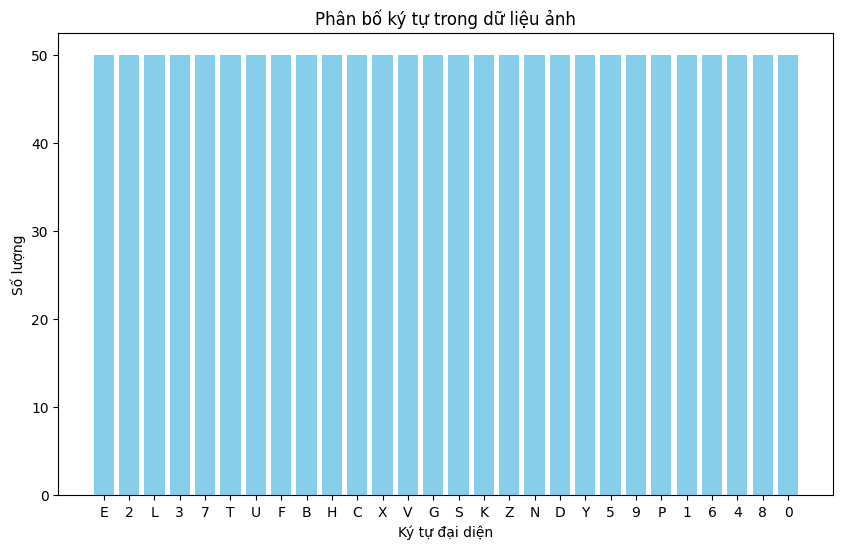

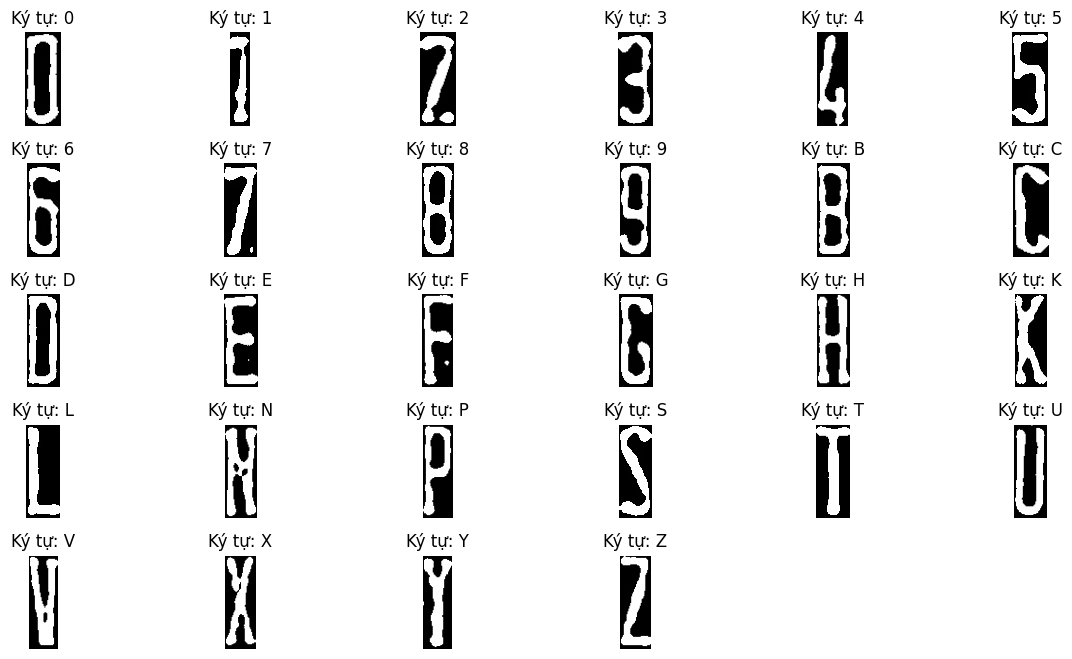

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Đường dẫn đến folder ảnh
folder_path = '/content/drive/MyDrive/Augment_Labeled'

# Lưu trữ ký tự đại diện và đường dẫn ảnh
image_data = []

# Duyệt qua từng file trong folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.jpg'):
        # Trích xuất ký tự đại diện từ tên file
        char = file_name[-5]  # ký tự cuối cùng trước ".jpg"
        image_data.append((char, os.path.join(folder_path, file_name)))

# Đếm tần số xuất hiện của từng ký tự
char_counts = Counter([item[0] for item in image_data])
for key, value in char_counts.items():
    print(f"{key}: {value}")

# Trực quan hóa phân bố ký tự
plt.figure(figsize=(10, 6))
plt.bar(char_counts.keys(), char_counts.values(), color='skyblue')
plt.xlabel('Ký tự đại diện')
plt.ylabel('Số lượng')
plt.title('Phân bố ký tự trong dữ liệu ảnh')
plt.show()

# Hiển thị một ảnh mẫu cho mỗi ký tự
unique_chars = list(set([item[0] for item in image_data]))
plt.figure(figsize=(12, 8))

for i, char in enumerate(sorted(unique_chars)):
    plt.subplot(6, 6, i+1)
    # Tìm ảnh đầu tiên đại diện cho ký tự
    sample_image_path = next(item[1] for item in image_data if item[0] == char)
    img = Image.open(sample_image_path)
    # plt.imshow(img)

    plt.imshow(img, cmap='gray')  # Sử dụng cmap 'gray' để hiển thị ảnh đen trắng

    plt.title(f'Ký tự: {char}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Tiền xử lý dữ liệu**

In [ ]:
import cv2
import os

# Đường dẫn đến thư mục chứa ảnh đầu vào và thư mục đầu ra
labeled_dir = "/content/drive/MyDrive/characters_labeled"
output_labeled_dir = "/content/drive/MyDrive/transform_labeled"

# Đảm bảo rằng các thư mục đầu ra tồn tại
os.makedirs(output_labeled_dir, exist_ok=True)

def reduce_glare(img):
    img_blurred = cv2.GaussianBlur(img, (5, 5), 0)
    img_reduced_glare = cv2.addWeighted(img, 1.5, img_blurred, -0.5, 0)
    return img_reduced_glare


def preprocess_image(LpImg):

    gray = cv2.cvtColor(LpImg, cv2.COLOR_BGR2GRAY)
    img_reduced_glare = reduce_glare(gray)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(img_reduced_glare)

    # Thay thế GaussianBlur bằng BilateralFilter để giữ lại cạnh của ký tự
    filtered = cv2.bilateralFilter(enhanced_gray, 9, 75, 75)

    # Inpainting để xử lý vùng bị bẩn (tuỳ chọn)
    mask = cv2.threshold(filtered, 240, 255, cv2.THRESH_BINARY)[1]
    inpainted = cv2.inpaint(filtered, mask, 3, cv2.INPAINT_TELEA)

    thresh = cv2.adaptiveThreshold(inpainted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 45, 15)
    return thresh

# Hàm xử lý tất cả ảnh trong thư mục
def process_images_in_directory(input_dir, output_dir):
    for filename in os.listdir(input_dir):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        if os.path.isfile(input_path):
            # Đọc ảnh gốc
            image = cv2.imread(input_path)

            # Tiền xử lý ảnh
            processed_image = preprocess_image(image)

            # Lưu ảnh đã tiền xử lý
            cv2.imwrite(output_path, processed_image)

# Tiền xử lý ảnh trong hai thư mục
process_images_in_directory(labeled_dir, output_labeled_dir)


# **Tăng cường dữ liệu**

In [ ]:
# Đọc ảnh nhị phân
image = cv2.imread('/content/drive/MyDrive/augment_labeled/000001_02_9.jpg', cv2.IMREAD_GRAYSCALE)

# Hiển thị kích thước ảnh
print(f'Kích thước ảnh: {image.shape}')


Kích thước ảnh: (100, 33)


In [ ]:
import cv2
import os
import numpy as np
import random

# Đường dẫn đến thư mục chứa ảnh đầu vào và thư mục đầu ra
output_labeled_dir = "/content/drive/MyDrive/transform_labeled"
augment_dir = "/content/drive/MyDrive/augment_labeled"

# Đảm bảo rằng thư mục đầu ra tồn tại
os.makedirs(augment_dir, exist_ok=True)

# Tập hợp để lưu trữ các nhãn đã được augment
processed_labels = set()

# Hàm thêm nhiễu đen vào pixel trắng gần biên của ký tự
def add_black_noise_to_edges(img, noise_factor=0.2):
    # Tìm biên của ký tự màu trắng (giá trị 255)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tạo một mặt nạ chứa các biên của ký tự
    edge_mask = np.zeros_like(img)
    cv2.drawContours(edge_mask, contours, -1, 255, thickness=cv2.FILLED)

    # Sinh ngẫu nhiên số lần xói mòn từ 1 đến 3
    erosion_iterations = random.randint(1, 3)

    # Xói mòn mặt nạ để xác định các pixel gần biên
    eroded_mask = cv2.erode(edge_mask, None, iterations=erosion_iterations)

    # Tạo mặt nạ cho các điểm có thể thêm nhiễu
    noise_mask = (edge_mask > eroded_mask) & (img == 255)

    # Chọn ngẫu nhiên các điểm trong mặt nạ để thêm nhiễu
    noise_points = np.random.rand(*img.shape) < noise_factor
    black_noise_mask = noise_mask & noise_points

    # Tạo ảnh mới với nhiễu đen thêm vào các pixel gần biên
    img_noisy = np.copy(img)
    img_noisy[black_noise_mask] = 0  # Đặt giá trị các điểm nhiễu thành 0 (màu đen)

    return img_noisy


# Hàm biến dạng hình học nhẹ (hàm này đã được giảm cường độ biến dạng)
def slight_warp(img):
    rows, cols = img.shape[:2]
    src_points = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
    dst_points = src_points + np.random.uniform(-3, 3, src_points.shape).astype(np.float32)
    warp_matrix = cv2.getAffineTransform(src_points, dst_points)
    img_warped = cv2.warpAffine(img, warp_matrix, (cols, rows))
    return img_warped

# Hàm dịch chuyển vị trí (hàm này đã được điều chỉnh cho phù hợp với kích thước ảnh hình chữ nhật)
def translate_image(img, max_tx=3, max_ty=5):
    rows, cols = img.shape[:2]

    # Dịch chuyển ngẫu nhiên trong khoảng [-max_tx, max_tx] cho tx, và [-max_ty, max_ty] cho ty
    tx = random.randint(-max_tx, max_tx)
    ty = random.randint(-max_ty, max_ty)

    # Ma trận dịch chuyển
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])

    # Áp dụng dịch chuyển lên ảnh
    img_translated = cv2.warpAffine(img, translation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return img_translated

# Hàm tăng cường dữ liệu
def augment_image(img):
    img_augmented = add_black_noise_to_edges(img, noise_factor=0.2)
    img_augmented = slight_warp(img_augmented)  # Biến dạng hình học nhẹ
    img_augmented = translate_image(img_augmented, max_tx=3, max_ty=5)  # Dịch chuyển hợp lý cho ảnh hình chữ nhật
    return img_augmented

# Hàm kiểm tra ký tự cuối là chữ cái hay số
def is_digit(label):
    return label.isdigit()

# Hàm xử lý các ảnh trong thư mục
def process_images_in_directory(input_dir, output_dir):
    for filename in os.listdir(input_dir):
        input_path = os.path.join(input_dir, filename)
        if os.path.isfile(input_path):
            # Đọc ảnh gốc
            image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

            # Lưu ảnh gốc vào thư mục augment
            original_output_path = os.path.join(output_dir, filename)
            cv2.imwrite(original_output_path, image)

            # Tách phần nhãn từ tên file
            base_name, ext = os.path.splitext(filename)
            label = base_name[-1]

            # Kiểm tra nếu nhãn đã được augment
            if label in processed_labels:
                continue  # Nếu nhãn đã được augment, bỏ qua

            base_name = base_name[:-2]  # Loại bỏ nhãn từ base_name

            # Xác định số lượng augment cần thiết
            if is_digit(label):
                num_augments = 10
            else:
                num_augments = 50

            # Tạo các ảnh augment và lưu chúng
            for i in range(1, num_augments + 1):
                augmented_image = augment_image(image)
                new_filename = f"{base_name}_{i:02d}_{label}{ext}"
                output_path = os.path.join(output_dir, new_filename)
                cv2.imwrite(output_path, augmented_image)

            # Thêm nhãn vào tập hợp đã xử lý
            processed_labels.add(label)

# Thực hiện tăng cường dữ liệu
process_images_in_directory(output_labeled_dir, augment_dir)


In [ ]:
import os
import random
import shutil
from PIL import Image
import cv2
import numpy as np

# Đường dẫn đến thư mục chứa ảnh đầu vào và thư mục đầu ra
output_labeled_dir = "/content/drive/MyDrive/transform_labeled"
augment_dir = "/content/drive/MyDrive/augment_labeled"

# Đảm bảo rằng thư mục đầu ra tồn tại
os.makedirs(augment_dir, exist_ok=True)

# Hàm thêm nhiễu đen vào pixel trắng gần biên của ký tự
def add_black_noise_to_edges(img, noise_factor):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    edge_mask = np.zeros_like(img)
    cv2.drawContours(edge_mask, contours, -1, 255, thickness=cv2.FILLED)
    erosion_iterations = random.randint(1, 3)
    eroded_mask = cv2.erode(edge_mask, None, iterations=erosion_iterations)
    noise_mask = (edge_mask > eroded_mask) & (img == 255)
    noise_points = np.random.rand(*img.shape) < noise_factor
    black_noise_mask = noise_mask & noise_points
    img_noisy = np.copy(img)
    img_noisy[black_noise_mask] = 0
    return img_noisy

# Hàm biến dạng hình học nhẹ
def slight_warp(img):
    rows, cols = img.shape[:2]
    src_points = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
    dst_points = src_points + np.random.uniform(-5, 5, src_points.shape).astype(np.float32)
    warp_matrix = cv2.getAffineTransform(src_points, dst_points)
    img_warped = cv2.warpAffine(img, warp_matrix, (cols, rows))
    return img_warped

# Hàm dịch chuyển vị trí
def translate_image(img, max_tx, max_ty):
    rows, cols = img.shape[:2]
    tx = random.randint(-max_tx, max_tx)
    ty = random.randint(-max_ty, max_ty)
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    img_translated = cv2.warpAffine(img, translation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return img_translated

# Hàm augment ảnh với các biến đổi ngẫu nhiên
def augment_image(image, count):
    augmented_images = []
    for _ in range(count):
        img_augmented = np.array(image)

        # Tạo các biến đổi ngẫu nhiên
        max_tx = random.randint(1, 3)
        max_ty = random.randint(1, 5)

        img_augmented = add_black_noise_to_edges(img_augmented, noise_factor = 0.2)
        img_augmented = slight_warp(img_augmented)
        img_augmented = translate_image(img_augmented, max_tx, max_ty)

        augmented_images.append(Image.fromarray(img_augmented))
    return augmented_images

# Số lượng ảnh cần đạt được cho mỗi nhãn
target_count = 50

# Lấy tất cả file trong folder
all_files = [f for f in os.listdir(output_labeled_dir) if os.path.isfile(os.path.join(output_labeled_dir, f))]

# Nhóm file theo nhãn cuối cùng trong tên file
label_files = {}
for file_name in all_files:
    label = file_name.split('_')[-1][0]
    if label not in label_files:
        label_files[label] = []
    label_files[label].append(file_name)

for label, files in label_files.items():
  print(f"Label: {label}, Count: {len(files)}")

# Xử lý từng nhãn
for label, files in label_files.items():
    count = len(files)
    if count > target_count:
        # Chọn ngẫu nhiên 50 ảnh nếu số lượng lớn hơn 50
        selected_files = random.sample(files, target_count)

        for file_name in selected_files:
            shutil.copy(os.path.join(output_labeled_dir, file_name), os.path.join(augment_dir, file_name))

    else:
        # Augment ảnh nếu số lượng nhỏ hơn 50
        augment_needed = target_count - count
        augment_per_image = augment_needed // count
        remainder = augment_needed % count

        for i, file_name in enumerate(files):
            image_path = os.path.join(output_labeled_dir, file_name)
            image = Image.open(image_path).convert("L")

            # Augment ảnh
            augmented_images = augment_image(image, augment_per_image + (1 if i < remainder else 0))

            # Lưu ảnh gốc
            shutil.copy(image_path, os.path.join(augment_dir, file_name))

            # Lưu các ảnh augment
            base_name, ext = os.path.splitext(file_name)
            name_parts = base_name.split('_')
            image_index = name_parts[-2]  # giữ số thứ tự của ảnh
            for j, augmented_image in enumerate(augmented_images):
                new_file_name = f"{name_parts[0]}_{image_index}_aug{j}_{label}{ext}"
                augmented_image.save(os.path.join(augment_dir, new_file_name))


Label: 5, Count: 167
Label: 9, Count: 144
Label: P, Count: 6
Label: 1, Count: 161
Label: 6, Count: 92
Label: 4, Count: 80
Label: 8, Count: 62
Label: 0, Count: 69
Label: E, Count: 7
Label: 2, Count: 93
Label: L, Count: 10
Label: 3, Count: 75
Label: 7, Count: 84
Label: T, Count: 6
Label: U, Count: 10
Label: F, Count: 13
Label: B, Count: 13
Label: H, Count: 10
Label: C, Count: 10
Label: X, Count: 5
Label: V, Count: 6
Label: G, Count: 5
Label: S, Count: 7
Label: K, Count: 4
Label: Z, Count: 4
Label: N, Count: 4
Label: D, Count: 7
Label: Y, Count: 4
